In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os

In [2]:
import os
# Function to extract patches from images
def extract_patches_from_image(image, patch_size):
    patches = []
    height, width = image.shape
    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

# Function to load and preprocess images
def load_and_preprocess_images(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = cv2.resize(image, (500, 500))  # Resize for faster processing
                images.append(image)
    return images

# Load and preprocess all images
images = load_and_preprocess_images('groupedtrain')
image_filenames = os.listdir('groupedtrain')  # Get filenames separately

# Define patch size
patch_size = 100

# Extract patches and label them
patches = []
labels = []
for image, filename in zip(images, image_filenames):
    image_patches = extract_patches_from_image(image, patch_size)
    patches.extend(image_patches)
    # Label patches based on the category of the image
    if "crater" in filename:
        labels.extend([1] * len(image_patches))  # Crater
    elif "sand_dune" in filename:
        labels.extend([2] * len(image_patches))  # Sand dune
    else:
        labels.extend([0] * len(image_patches))  # Normal land
    # Print debug information
    print(f"Image: {filename}, Number of patches: {len(image_patches)}, Assigned label: {labels[-1]}")

# Convert patches and labels to numpy arrays
patches = np.array(patches)
labels = np.array(labels)

# Print the total number of patches and labels for verification
print("Total number of patches:", len(patches))
print("Total number of labels:", len(labels))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(patches, labels, test_size=0.2, random_state=0)


Image: crater (2).jpg, Number of patches: 25, Assigned label: 1
Image: crater (3).jpg, Number of patches: 25, Assigned label: 1
Image: crater (4).jpg, Number of patches: 25, Assigned label: 1
Image: crater.jpg, Number of patches: 25, Assigned label: 1
Image: dunes.jpg, Number of patches: 25, Assigned label: 0
Image: Land1.jpg, Number of patches: 25, Assigned label: 0
Image: Land2.jpg, Number of patches: 25, Assigned label: 0
Image: Land3.jpg, Number of patches: 25, Assigned label: 0
Image: Land4.jpg, Number of patches: 25, Assigned label: 0
Image: Land5.jpg, Number of patches: 25, Assigned label: 0
Total number of patches: 250
Total number of labels: 250


In [3]:
## Train SVM classifier
#svm_classifier = SVC(kernel='linear')
#svm_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)

## Predict on test set
#y_pred = svm_classifier.predict(X_test.reshape(X_test.shape[0], -1))

## Calculate accuracy
#accuracy = accuracy_score(y_test, y_pred)
#print("SVM Accuracy:", accuracy)


In [4]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
history = model.fit(X_train[..., np.newaxis], y_train, epochs=15, validation_split=0.2)

# Evaluate CNN model
test_loss, test_acc = model.evaluate(X_test[..., np.newaxis], y_test)
print("CNN Accuracy:", test_acc)







Epoch 1/15


5/5 [==============================] - 3s 198ms/step - loss: 61.8289 - accuracy: 0.3938 - val_loss: 17.6087 - val_accuracy: 0.5500
Epoch 2/15
5/5 [==============================] - 1s 102ms/step - loss: 10.9182 - accuracy: 0.5375 - val_loss: 14.1486 - val_accuracy: 0.5500
Epoch 3/15
5/5 [==============================] - 0s 95ms/step - loss: 7.3514 - accuracy: 0.5688 - val_loss: 1.5274 - val_accuracy: 0.6250
Epoch 4/15
5/5 [==============================] - 0s 99ms/step - loss: 0.7632 - accuracy: 0.6812 - val_loss: 0.8989 - val_accuracy: 0.7000
Epoch 5/15
5/5 [==============================] - 1s 106ms/step - loss: 0.4272 - accuracy: 0.7875 - val_loss: 0.6508 - val_accuracy: 0.5500
Epoch 6/15
5/5 [==============================] - 0s 93ms/step - loss: 0.3949 - accuracy: 0.8438 - val_loss: 0.7292 - val_accuracy: 0.6250
Epoch 7/15
5/5 [==============================] - 0s 98ms/step - loss: 0.4433 - accuracy: 0.7812 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 8/15
5/5 

In [5]:
# Predict probabilities using CNN model
y_prob = model.predict(X_test[..., np.newaxis])

# Threshold function to consider values smaller than threshold_value as 0
def threshold_probabilities(probabilities, threshold_value):
    probabilities[probabilities < threshold_value] = 0
    return probabilities

# Threshold probabilities using the threshold function
threshold_value = 0.001
y_prob_thresholded = threshold_probabilities(y_prob, threshold_value)

# Display thresholded probabilities of the presence of craters and sand dunes
for i, prob in enumerate(y_prob_thresholded):
    print(f"Patch {i+1}: Probability of Crater: {prob[1]}, Probability of Sand Dune: {prob[2]}")


2/2 [==============================] - 0s 20ms/step
Patch 1: Probability of Crater: 0.7336944937705994, Probability of Sand Dune: 0.0
Patch 2: Probability of Crater: 0.44762176275253296, Probability of Sand Dune: 0.0
Patch 3: Probability of Crater: 1.0, Probability of Sand Dune: 0.0
Patch 4: Probability of Crater: 0.0, Probability of Sand Dune: 0.0
Patch 5: Probability of Crater: 0.5463062524795532, Probability of Sand Dune: 0.0
Patch 6: Probability of Crater: 0.5098972320556641, Probability of Sand Dune: 0.0
Patch 7: Probability of Crater: 0.5905664563179016, Probability of Sand Dune: 0.0
Patch 8: Probability of Crater: 0.5041845440864563, Probability of Sand Dune: 0.0
Patch 9: Probability of Crater: 0.6417911052703857, Probability of Sand Dune: 0.0
Patch 10: Probability of Crater: 0.6006203889846802, Probability of Sand Dune: 0.0
Patch 11: Probability of Crater: 0.78737473487854, Probability of Sand Dune: 0.0
Patch 12: Probability of Crater: 0.25373613834381104, Probability of Sand D

In [9]:
# Function to display probabilities and patch names
def display_probabilities_with_names(patch_probabilities):
    for i, (prob, name) in enumerate(patch_probabilities):
        if prob[1] > 0.5:
            print(f"Patch {i+1} has more than 50% probability of having a crater: {name}")

# Generate patch names
patch_names = [f"Patch_{i+1}" for i in range(len(example_patch_group))]

# Combine probabilities with patch names
patch_probabilities = list(zip(y_prob_thresholded, patch_names))

# Display probabilities and patch names
display_probabilities_with_names(patch_probabilities)


Patch 1 has more than 50% probability of having a crater: Patch_1
Patch 3 has more than 50% probability of having a crater: Patch_3
Patch 5 has more than 50% probability of having a crater: Patch_5
Patch 6 has more than 50% probability of having a crater: Patch_6
Patch 7 has more than 50% probability of having a crater: Patch_7
Patch 8 has more than 50% probability of having a crater: Patch_8
Patch 9 has more than 50% probability of having a crater: Patch_9
Patch 10 has more than 50% probability of having a crater: Patch_10
Patch 11 has more than 50% probability of having a crater: Patch_11
Patch 13 has more than 50% probability of having a crater: Patch_13
Patch 14 has more than 50% probability of having a crater: Patch_14
Patch 15 has more than 50% probability of having a crater: Patch_15
Patch 16 has more than 50% probability of having a crater: Patch_16
Patch 18 has more than 50% probability of having a crater: Patch_18
Patch 20 has more than 50% probability of having a crater: Pat

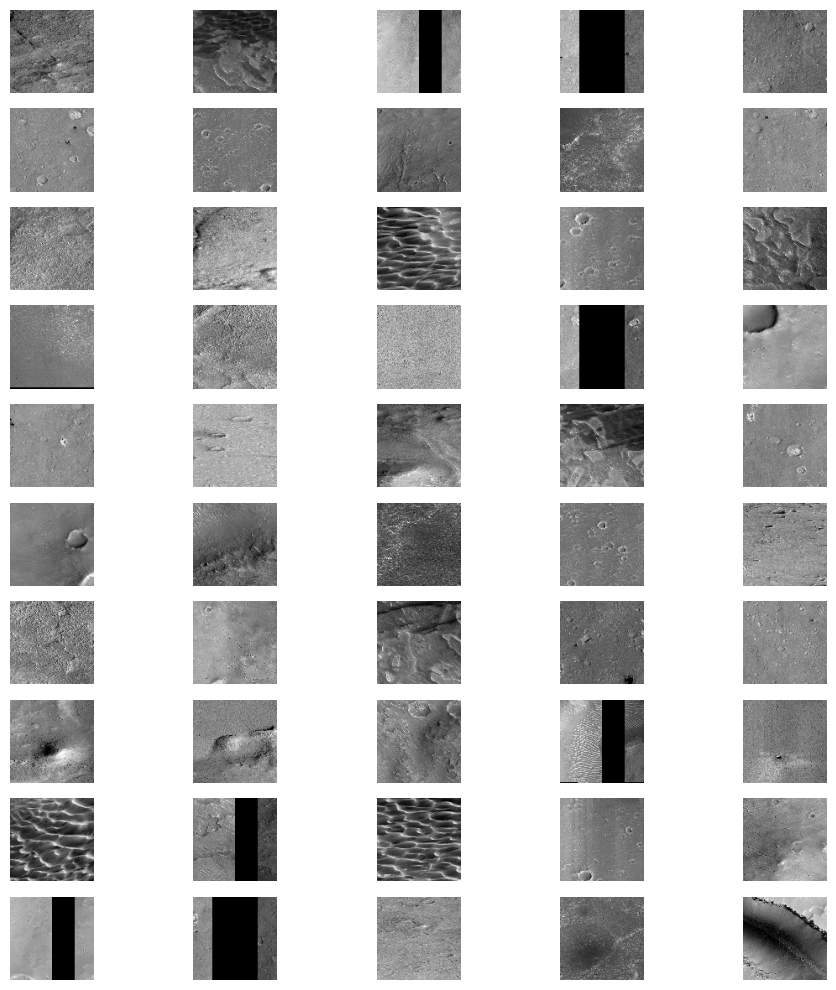

In [6]:
import matplotlib.pyplot as plt

# Function to display a group of patches in a grid
def display_patch_group(patch_group, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    total_plots = num_rows * num_cols
    for i in range(min(num_rows, len(patch_group))):
        for j in range(min(num_cols, len(patch_group) - i * num_cols)):
            ax = axes[i, j]
            ax.imshow(patch_group[i * num_cols + j], cmap='gray')
            ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

# Choose a group of example patches (e.g., the first 50 patches in X_test)
example_patch_group = X_test[:50]  # Assuming X_test is in the shape (num_samples, height, width)

# Calculate the number of rows and columns for the grid
num_rows = min(10, len(example_patch_group))  # Adjust based on the number of patches available
num_cols = min(10, (len(example_patch_group) + 9) // 10)  # Adjust based on the number of patches available

# Display the example patch group in a grid
display_patch_group(example_patch_group, num_rows, num_cols)
